<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/Project_full_code_final_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project name-
Lifestyle-based Disease Risk Prediction using Machine Learning**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Pre processing**


In [ ]:
file_path = '/content/drive/My Drive/health_lifestyle_classification.csv'

df = pd.read_csv(file_path)
print("Initial shape:", df.shape)
print(df.head())

print(df['target'].value_counts(dropna=False))

Initial shape: (100000, 48)
   survey_code  age  gender      height     weight        bmi  bmi_estimated  \
0            1   56    Male  173.416872  56.886640  18.915925      18.915925   
1            2   69  Female  163.207380  97.799859  36.716278      36.716278   
2            3   46    Male  177.281966  80.687562  25.673050      25.673050   
3            4   32  Female  172.101255  63.142868  21.318480      21.318480   
4            5   60  Female  163.608816  40.000000  14.943302      14.943302   

   bmi_scaled  bmi_corrected  waist_size  ...  sunlight_exposure  \
0   56.747776      18.989117   72.165130  ...               High   
1  110.148833      36.511417   85.598889  ...               High   
2   77.019151      25.587429   90.295030  ...               High   
3   63.955440      21.177109  100.504211  ...               High   
4   44.829907      14.844299   69.021150  ...               High   

   meals_per_day  caffeine_intake  family_history  pet_owner  \
0              5  

In [ ]:
df_raw = pd.read_csv(file_path)
print(df_raw['target'].value_counts(dropna=False))
print(df_raw['target'].unique())
#print(df_raw.head())


target
healthy     70097
diseased    29903
Name: count, dtype: int64
['healthy' 'diseased']


In [ ]:
# FIX TARGET COLUMN FIRST

# Lowercase + strip spaces
df['target'] = df['target'].astype(str).str.lower().str.strip()

# Remove missing target rows (rare but safe)
df = df[df['target'].notna()]

# Encode binary target
df['target'] = df['target'].map({
    'healthy': 0,
    'diseased': 1
})

# Verify target
print("\nTarget check:", df['target'].unique())
print("Missing target:", df['target'].isna().sum())


Target check: [0 1]
Missing target: 0


In [ ]:
#---------------------------- Irrelevant Data check ----------------------------
# 1. Columns with only ONE unique value (constant)

constant_cols = [col for col in df.columns if df[col].nunique() == 1]

print("\n=== CONSTANT COLUMNS (DROP THESE) ===")
print(constant_cols)


=== CONSTANT COLUMNS (DROP THESE) ===
['electrolyte_level', 'gene_marker_flag', 'environmental_risk_score']


In [ ]:
# 2. Near-constant columns (>= 99% same value)

near_constant_cols = []

for col in df.columns:
    top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
    if top_freq >= 0.99 and df[col].nunique() > 1:
        near_constant_cols.append(col)

print("\n=== NEAR-CONSTANT COLUMNS (ALMOST NO INFORMATION) ===")
print(near_constant_cols)


=== NEAR-CONSTANT COLUMNS (ALMOST NO INFORMATION) ===
[]


In [ ]:
# 3. ID-like numeric columns (monotonic increasing or index-like)

id_like_cols = []

for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        # Check if column is strictly increasing by 1 or similar
        if df[col].is_monotonic_increasing:
            # Prevent false detection for numeric features
            first, last = df[col].iloc[0], df[col].iloc[-1]
            if (last - first + 1) == len(df):
                id_like_cols.append(col)

print("\n=== ID-LIKE COLUMNS (DROP THESE) ===")
print(id_like_cols)


=== ID-LIKE COLUMNS (DROP THESE) ===
['survey_code']


In [ ]:
# 4. Numerical columns with extremely low variance

low_variance_cols = []

for col in df.select_dtypes(include=['float64','int64']):
    if df[col].std() < 0.01:  # threshold can be adjusted
        low_variance_cols.append(col)

print("\n=== LOW VARIANCE NUMERIC COLUMNS (PROBABLY USELESS) ===")
print(low_variance_cols)


=== LOW VARIANCE NUMERIC COLUMNS (PROBABLY USELESS) ===
['electrolyte_level', 'gene_marker_flag', 'environmental_risk_score']


In [ ]:
# 5. Combine all irrelevant columns

all_irrelevant = list(set(constant_cols + near_constant_cols + id_like_cols + low_variance_cols))

print("\n=== FINAL IRRELEVANT COLUMNS TO DROP ===")
print(all_irrelevant)


=== FINAL IRRELEVANT COLUMNS TO DROP ===
['gene_marker_flag', 'survey_code', 'electrolyte_level', 'environmental_risk_score']


In [ ]:
# DROP IRRELEVANT COLUMNS

cols_to_drop = [
    'electrolyte_level',
    'environmental_risk_score',
    'gene_marker_flag',
    'survey_code'
]

df = df.drop(columns=cols_to_drop, errors='ignore')

print("\nAfter drop:", df.shape)



After drop: (100000, 44)


Categorical: ['gender', 'sleep_quality', 'alcohol_consumption', 'smoking_level', 'mental_health_support', 'education_level', 'job_type', 'occupation', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'insurance', 'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner']
Numeric: ['age', 'height', 'weight', 'bmi', 'bmi_estimated', 'bmi_scaled', 'bmi_corrected', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'income', 'meals_per_day', 'daily_supplement_dosage']

=== BASIC DATASET INFO ===
Shape: (100000, 44)

Column types:
 age                          int64
gender                      object
height                     float64
weight                     float64
bmi                        float64
bmi_estimated              float64
bmi_scaled                

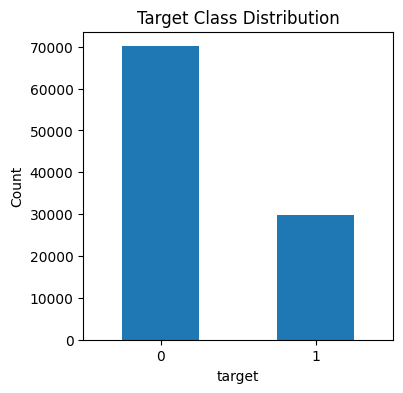


Target value counts (0=healthy, 1=diseased):
target
0    0.70097
1    0.29903
Name: proportion, dtype: float64

=== NUMERIC SUMMARY (first 10 cols) ===
                   count        mean        std         min         25%  \
age             100000.0   48.525990  17.886768   18.000000   33.000000   
height          100000.0  170.023707   9.982798  140.000000  163.306615   
weight          100000.0   70.064862  14.693667   40.000000   59.856938   
bmi             100000.0   24.493876   5.951069    9.988495   20.271405   
bmi_estimated   100000.0   24.493876   5.951069    9.988495   20.271405   
bmi_scaled      100000.0   73.481627  17.853206   29.965484   60.814215   
bmi_corrected   100000.0   24.494140   5.954184    9.893845   20.271059   
waist_size      100000.0   84.933043  12.040314   34.093185   76.795185   
blood_pressure   92331.0  119.980149  15.015503   59.128168  109.812060   
heart_rate       85997.0   74.969177   9.941668   34.745092   68.275432   

                     

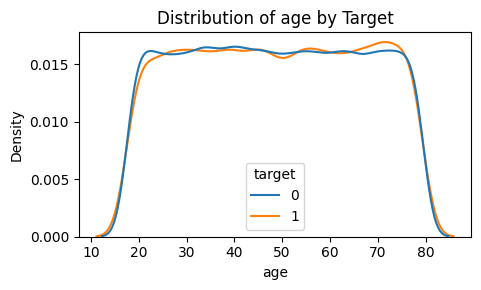

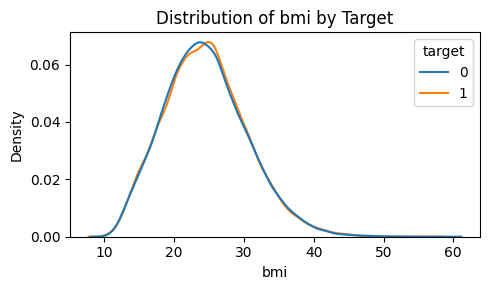

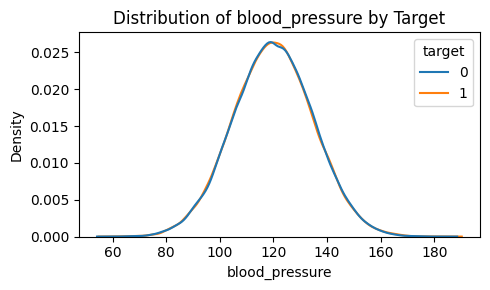

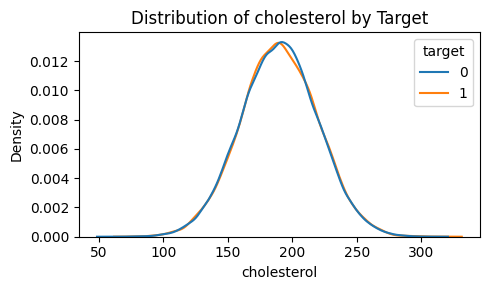

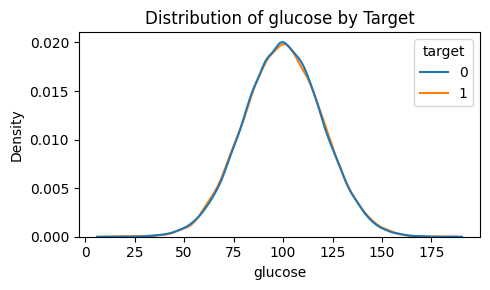

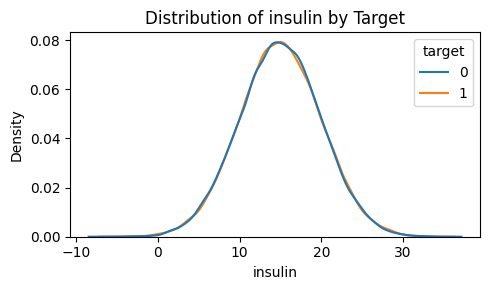


=== CORRELATION WITH TARGET ===
work_hours                -0.010906
daily_steps               -0.005054
meals_per_day             -0.002914
blood_pressure            -0.002640
water_intake              -0.001848
height                    -0.001453
physical_activity         -0.001298
stress_level              -0.000767
sugar_intake              -0.000398
heart_rate                -0.000054
screen_time                0.000134
insulin                    0.000136
calorie_intake             0.000254
income                     0.000379
daily_supplement_dosage    0.000465
glucose                    0.000483
waist_size                 0.000553
mental_health_score        0.001360
cholesterol                0.001529
sleep_hours                0.001663
bmi_corrected              0.002419
bmi                        0.002527
bmi_estimated              0.002527
bmi_scaled                 0.002527
weight                     0.002626
age                        0.006951
target                     1.00

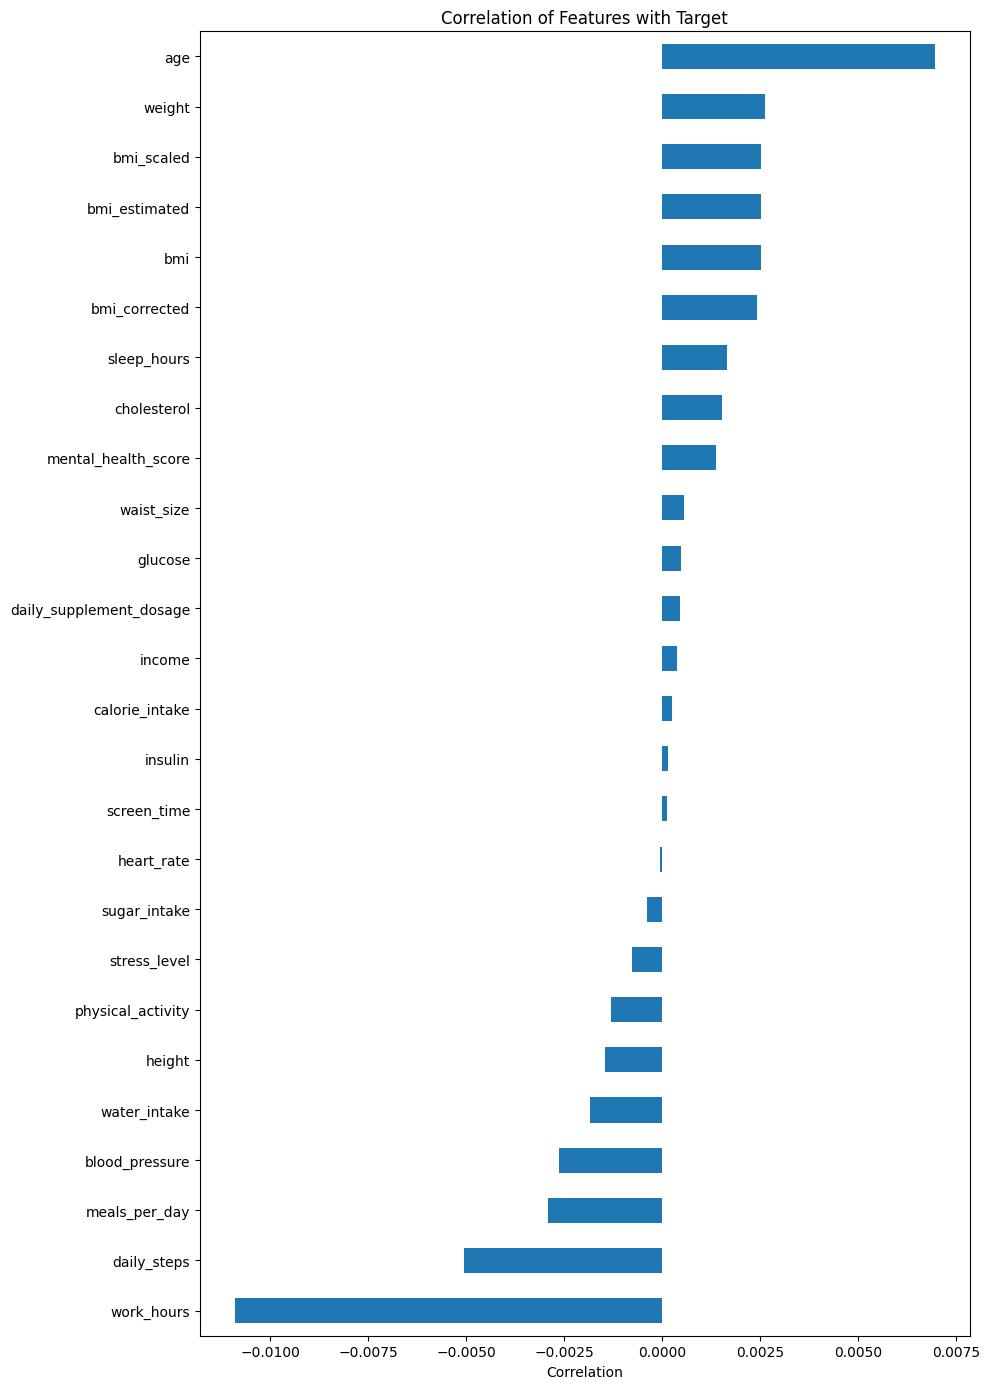

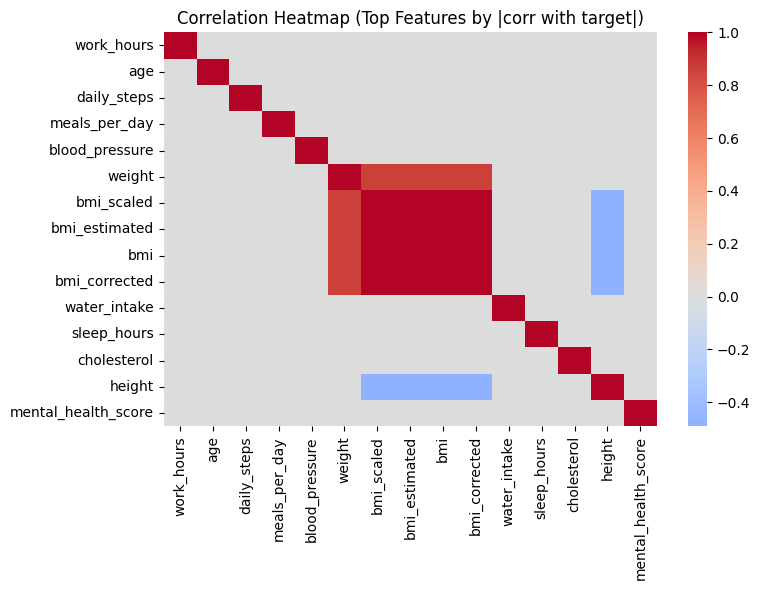


Categorical columns: ['gender', 'sleep_quality', 'alcohol_consumption', 'smoking_level', 'mental_health_support', 'education_level', 'job_type', 'occupation', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'insurance', 'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner']
Numerical columns: ['age', 'height', 'weight', 'bmi', 'bmi_estimated', 'bmi_scaled', 'bmi_corrected', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'income', 'meals_per_day', 'daily_supplement_dosage']


In [ ]:
#  IDENTIFY COLUMN TYPES

import seaborn as sns
plt.style.use("default")

# 1) Try to convert to numeric where possible
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

# 2) Convert any remaining bools to int
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
for col in bool_cols:
    df[col] = df[col].astype(int)

# 3) Now rebuild cat_cols and num_cols cleanly
cat_cols = [
    col for col in df.columns
    if df[col].dtype == 'object' and col != 'target'
]

num_cols = [
    col for col in df.columns
    if df[col].dtype != 'object' and col != 'target'
]

print("Categorical:", cat_cols)
print("Numeric:", num_cols)



# ==============================
# EDA SECTION
# ==============================

print("\n=== BASIC DATASET INFO ===")
print("Shape:", df.shape)
print("\nColumn types:\n", df.dtypes)

print("\nMissing values per column:\n", df.isna().sum())

# 1) Target distribution
plt.figure(figsize=(4,4))
df['target'].value_counts().plot(kind='bar')
plt.title("Target Class Distribution")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

print("\nTarget value counts (0=healthy, 1=diseased):")
print(df['target'].value_counts(normalize=True).rename("proportion"))

# 2) Summary stats for numeric features
print("\n=== NUMERIC SUMMARY (first 10 cols) ===")
print(df[num_cols].describe().T.head(10))

# 3) Compare means by target (you already did this later, but here in EDA)
group_means = df.groupby('target')[num_cols].mean().T
print("\n=== GROUP MEANS BY TARGET (first 15 features) ===")
print(group_means.head(15))

#  visualize a few important features vs target
key_feats = ['age', 'bmi', 'blood_pressure', 'cholesterol', 'glucose', 'insulin']
key_feats = [f for f in key_feats if f in df.columns]

for col in key_feats:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df, x=col, hue='target', common_norm=False)
    plt.title(f"Distribution of {col} by Target")
    plt.tight_layout()
    plt.show()

# 4) Correlation with target
corr_with_target = df[num_cols + ['target']].corr()['target'].sort_values()
print("\n=== CORRELATION WITH TARGET ===")
print(corr_with_target)

plt.figure(figsize=(10,14))
corr_with_target.drop('target').plot(kind='barh')
plt.title("Correlation of Features with Target")
plt.xlabel("Correlation")
#plt.xlim(-0.02, 0.02)
plt.tight_layout()
plt.show()

# 5) Small correlation heatmap (top ~15 features by abs corr)
top_feats = corr_with_target.abs().sort_values(ascending=False).index[1:16]  # skip 'target' itself
plt.figure(figsize=(8,6))
sns.heatmap(df[top_feats].corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Top Features by |corr with target|)")
plt.tight_layout()
plt.show()




print("\nCategorical columns:", cat_cols)
print("Numerical columns:", num_cols)


In [ ]:
#  HANDLE MISSING VALUES

# Fill categorical missing with 'missing'
for col in cat_cols:
    df[col] = df[col].fillna("missing")

# Fill numeric missing with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
#  FIX OUTLIERS (AFTER missing values)

def outlier_thresholds(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

def replace_outliers(df, col):
    low, high = outlier_thresholds(df, col)
    med = df[col].median()
    df[col] = np.where((df[col] < low) | (df[col] > high), med, df[col])

# --- FIX OUTLIERS ONLY FOR TRUE CONTINUOUS FEATURES ---

continuous_features = [
    'height', 'weight', 'bmi', 'bmi_corrected', 'waist_size',
    'blood_pressure', 'heart_rate', 'cholesterol', 'glucose',
    'insulin', 'daily_supplement_dosage'
]

for col in continuous_features:
    if col in df.columns:
        replace_outliers(df, col)


In [ ]:
# ENCODE CATEGORICAL FEATURES

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df[cat_cols] = enc.fit_transform(df[cat_cols])

In [ ]:
# TRAIN-TEST SPLIT (80/20)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("target", axis=1)
y = df["target"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
#  SCALE ONLY NUMERIC COLUMNS

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])


print("\nPreprocessing complete.")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Preprocessing complete.
Train shape: (80000, 43)
Test shape: (20000, 43)


In [ ]:
df_raw.dtypes


,0
survey_code,int64
age,int64
gender,object
height,float64
weight,float64
bmi,float64
bmi_estimated,float64
bmi_scaled,float64
bmi_corrected,float64
waist_size,float64


In [ ]:
df.shape

(100000, 44)

In [ ]:
# Zero null value verify

df['target'].isna().sum()


np.int64(0)

In [ ]:
# healthy and diseased data in target

print(df['target'].unique())
print(df['target'].value_counts(dropna=False))
print(df['target'].isna().sum())


[0 1]
target
0    70097
1    29903
Name: count, dtype: int64
0


In [ ]:
df.isna().sum().sum()


np.int64(0)

In [ ]:
df.isna().sum().sort_values(ascending=False)


,0
age,0
gender,0
height,0
weight,0
bmi,0
bmi_estimated,0
bmi_scaled,0
bmi_corrected,0
waist_size,0
blood_pressure,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      100000 non-null  int64  
 1   gender                   100000 non-null  float64
 2   height                   100000 non-null  float64
 3   weight                   100000 non-null  float64
 4   bmi                      100000 non-null  float64
 5   bmi_estimated            100000 non-null  float64
 6   bmi_scaled               100000 non-null  float64
 7   bmi_corrected            100000 non-null  float64
 8   waist_size               100000 non-null  float64
 9   blood_pressure           100000 non-null  float64
 10  heart_rate               100000 non-null  float64
 11  cholesterol              100000 non-null  float64
 12  glucose                  100000 non-null  float64
 13  insulin                  100000 non-null  float64
 14  sleep

In [ ]:
print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))


Train distribution:
target
0    0.700975
1    0.299025
Name: proportion, dtype: float64

Test distribution:
target
0    0.70095
1    0.29905
Name: proportion, dtype: float64


In [ ]:
print((X_train.nunique() == 1).sum())
print(X_train.nunique())


0
age                           62
gender                         2
height                     79407
weight                     77910
bmi                        79241
bmi_estimated              79997
bmi_scaled                 79997
bmi_corrected              79241
waist_size                 79441
blood_pressure             72806
heart_rate                 66791
cholesterol                79453
glucose                    79455
insulin                    65079
sleep_hours                79687
sleep_quality                  4
work_hours                 79998
physical_activity          74532
daily_steps                72759
calorie_intake             80000
sugar_intake               80000
alcohol_consumption            3
smoking_level                  3
water_intake               78802
screen_time                78202
stress_level                  11
mental_health_score           11
mental_health_support          2
education_level                4
job_type                       6
occupati

In [ ]:
print(df.corr()['target'].sort_values())


work_hours                -0.010906
daily_steps               -0.004842
healthcare_access         -0.003740
blood_pressure            -0.003702
exercise_type             -0.003299
meals_per_day             -0.002914
caffeine_intake           -0.002355
height                    -0.001942
water_intake              -0.001848
mental_health_support     -0.001678
smoking_level             -0.001578
physical_activity         -0.001298
device_usage              -0.001230
gender                    -0.000916
insurance                 -0.000904
stress_level              -0.000767
sunlight_exposure         -0.000419
sugar_intake              -0.000398
waist_size                -0.000369
pet_owner                  0.000098
family_history             0.000133
screen_time                0.000134
calorie_intake             0.000254
income                     0.000344
daily_supplement_dosage    0.000465
glucose                    0.000741
insulin                    0.001250
diet_type                  0

In [ ]:
X_train.var().sort_values()



,0
pet_owner,0.250000
mental_health_support,0.250001
gender,0.250002
family_history,0.250003
insurance,0.250003
smoking_level,0.665199
sunlight_exposure,0.665780
caffeine_intake,0.666432
healthcare_access,0.666645
device_usage,0.667480


**Logistic Regression (LR)**



Logistic Regression Metrics
--------------------------------
Accuracy : 0.4989
Precision: 0.2957
Recall   : 0.4890
F1 Score : 0.3686

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.50      0.58     14019
           1       0.30      0.49      0.37      5981

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.58      0.50      0.52     20000



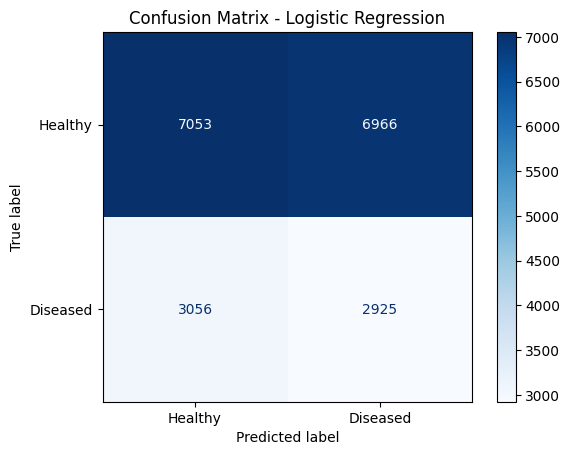

/tmp/ipython-input-3560269971.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette=colors)


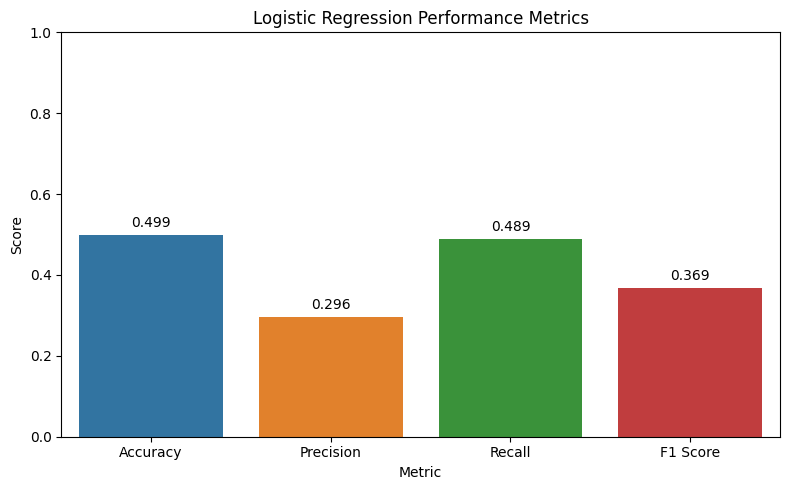


Sample predicted probabilities: [0.50857922 0.50745486 0.50743933 0.49175216 0.51335527 0.51160038
 0.48701635 0.51595889 0.48784447 0.50257638]


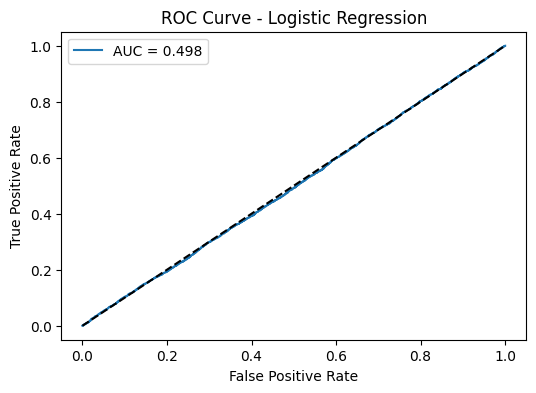

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Train logistic regression


logreg_model = LogisticRegression(
    max_iter=1000,      # Increase iterations for convergence
    class_weight='balanced',  # Handles imbalance (70/30)
    solver='lbfgs',
    C=0.1     # stronger regularization
)

logreg_model.fit(X_train, y_train)


# Predict funtion


y_pred = logreg_model.predict(X_test)

# -------------------------------------------------------
# EVALUATION METRICS (ACCURACY PRECISION RECALL F1 SCORE)
# -------------------------------------------------------


acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("\nLogistic Regression Metrics")
print("--------------------------------")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------------------------------------------
#  CONFUSION MATRIX FOR LR
# -------------------------------------------------------

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diseased'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# CREATE BAR PLOT

# Store metrics
metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette=colors)

plt.ylim(0, 1)  # scores range between 0 and 1
plt.title("Logistic Regression Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")

# Annotate bars with values
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# ROC PLOT FOR LOGISTIC REGRESSION
# -------------------------------------------------------

y_prob = logreg_model.predict_proba(X_test)[:, 1]  # Probability of class = 1
print("\nSample predicted probabilities:", y_prob[:10])

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()





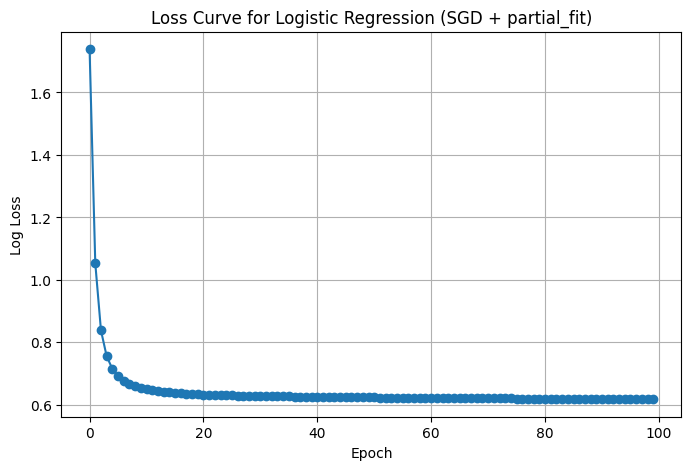

In [ ]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt

# Initialize SGD Logistic Regression
sgd_logreg = SGDClassifier(
    loss='log_loss',      # logistic regression
    learning_rate='optimal',
    penalty='l2',
    max_iter=1,           # we manually control epochs
    warm_start=True,
    random_state=42
)

# ---- Manual training loop to collect loss ----
loss_history = []

n_epochs = 100  # Number of epochs to train

classes = np.unique(y_train)  # needed for partial_fit

for epoch in range(n_epochs):
    sgd_logreg.partial_fit(X_train, y_train, classes=classes)

    # Compute current loss for entire training set
    y_prob = sgd_logreg.predict_proba(X_train)
    epsilon = 1e-8  # avoid log(0)
    loss = -np.mean(
        y_train * np.log(y_prob[:,1] + epsilon) +
        (1 - y_train) * np.log(1 - y_prob[:,1] + epsilon)
    )

    loss_history.append(loss)

# ---- Plotting the loss curve ----
plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o')
plt.title("Loss Curve for Logistic Regression (SGD + partial_fit)")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()


In [ ]:
df.groupby('target').mean().T


target,0,1
age,48.444784,48.716350
gender,0.501619,0.500619
height,170.042957,170.002021
weight,69.893044,69.962043
bmi,24.305543,24.341642
bmi_estimated,24.484052,24.516903
bmi_scaled,73.452157,73.550709
bmi_corrected,24.306765,24.338674
waist_size,84.940998,84.931616
blood_pressure,120.011284,119.901279


Neural Netwrok


Using device: cpu
NN(
  (model): Sequential(
    (0): Linear(in_features=43, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
Epoch 0/100 | Train Loss: 0.6133 | Val Loss: 0.6115 | Train Acc: 0.701 | Val Acc: 0.701
Epoch 10/100 | Train Loss: 0.5989 | Val Loss: 0.6369 | Train Acc: 0.703 | Val Acc: 0.688
Epoch 20/100 | Train Loss: 0.5818 | Val Loss: 0.7039 | Train Acc: 0.711 | Val Acc: 0.690
Epoch 30/100 | Train Loss: 0.5707 | Val Loss: 0.7130 | Train Acc: 0.718 | Val Acc: 0.676
Epoch 40/100 | Train Loss: 0.5617 | Val Loss: 0.7535 | Train Acc: 0.723 | Val Acc: 0.679
Epoch 50/100 | Train Loss: 0.5550 | Val Loss: 0.7705 | Train Acc: 0.728 | Val Acc: 0.664
Epoch 60/100 | Train Loss: 0.5502 | Val Loss: 0.8349 | Train Acc: 0.729 | Val Acc: 0.677
Epoch 70/100 | Train Loss: 0.5458 | Val 

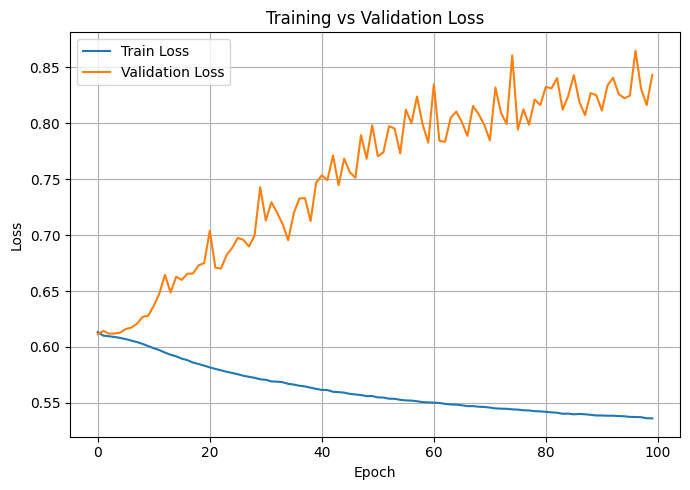

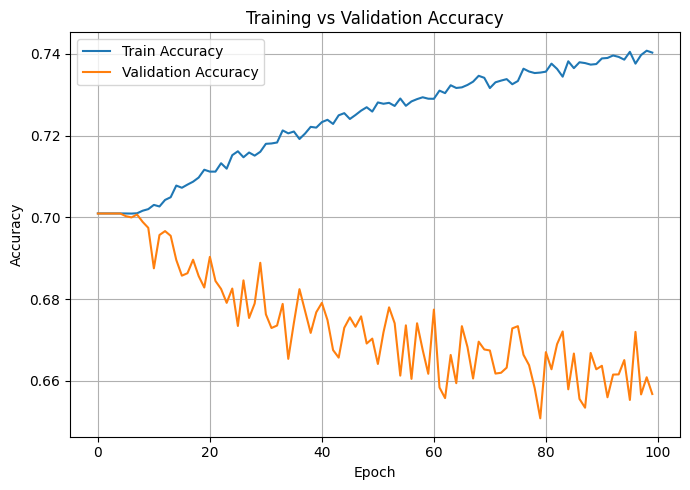


[ANN] Validation Metrics:
Accuracy : 0.6568
Precision: 0.2882
Recall   : 0.1005
F1 Score : 0.1490


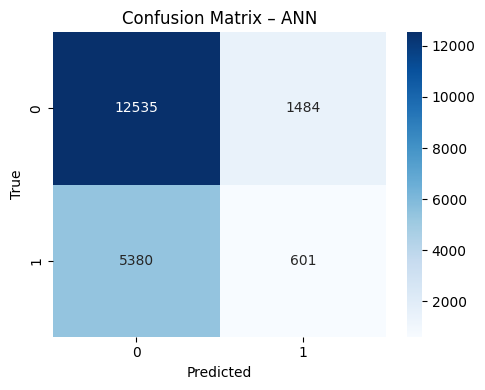

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# ============================================
# SCALING
# ============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled   = scaler.transform(X_test)


# ============================================
# CONVERT TO TENSORS
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1).to(device)

X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                          batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                          batch_size=64, shuffle=False)


# ============================================
# DEFINE MULTI-LAYER NEURAL NETWORK
# ============================================
input_dim = X_train.shape[1]

class NN(nn.Module):
    def __init__(self, in_features):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x)

model = NN(input_dim).to(device)
print(model)

# ============================================
#  LOSS & OPTIMIZER
# ============================================
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ============================================
#  TRAINING LOOP
# ============================================
num_epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):

    # ---- Training ----
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        out = model(xb)
        loss = criterion(out, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- Compute Train Accuracy ----
    model.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for xb, yb in train_loader:
            out = model(xb)
            probs = torch.sigmoid(out)
            preds = (probs >= 0.5).float()
            correct_train += (preds == yb).sum().item()
            total_train += yb.size(0)
    epoch_train_acc = correct_train / total_train
    train_accs.append(epoch_train_acc)

    # ---- Validation ----
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            loss = criterion(out, yb)
            total_val_loss += loss.item() * xb.size(0)

            probs = torch.sigmoid(out)
            preds = (probs >= 0.5).float()
            correct_val += (preds == yb).sum().item()
            total_val += yb.size(0)

    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    epoch_val_acc = correct_val / total_val
    val_accs.append(epoch_val_acc)

    if epoch % 10 == 0 or epoch == 0:
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
            f"Train Acc: {epoch_train_acc:.3f} | Val Acc: {epoch_val_acc:.3f}"
        )

# ============================================
#  PLOT TRAIN VS VALIDATION LOSS
# ============================================
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ============================================
#  PLOT TRAIN VS VALIDATION ACCURACY
# ============================================
plt.figure(figsize=(7,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ============================================
# FINAL METRICS (ANN: Accuracy, Precision, Recall, F1)
# ============================================
model.eval()
with torch.no_grad():
    logits = model(X_val_tensor)
    probs = torch.sigmoid(logits).cpu().numpy().ravel()
    y_pred = (probs >= 0.5).astype(int)

# Metrics for ANN
ann_acc = accuracy_score(y_test, y_pred)
ann_prec, ann_rec, ann_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary', zero_division=0
)

print("\n[ANN] Validation Metrics:")
print(f"Accuracy : {ann_acc:.4f}")
print(f"Precision: {ann_prec:.4f}")
print(f"Recall   : {ann_rec:.4f}")
print(f"F1 Score : {ann_f1:.4f}")

# ============================================
# CONFUSION MATRIX (ANN)
# ============================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ANN")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3088719209.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ann_metrics.keys()),


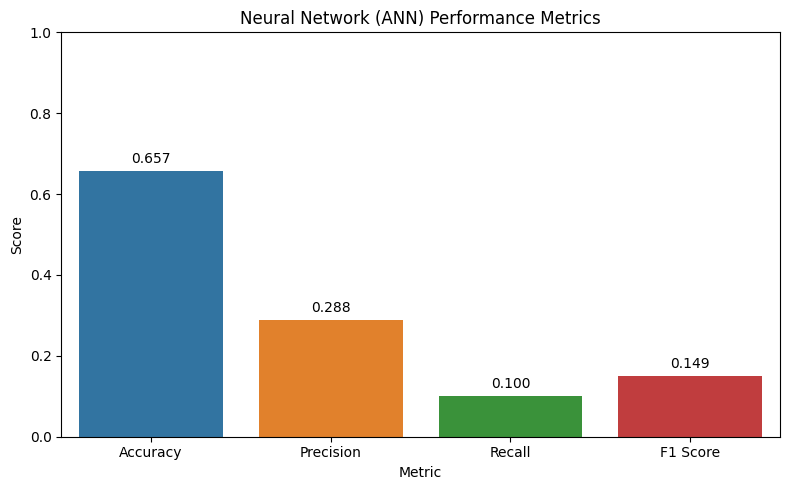

In [ ]:
# ============================================
# BAR PLOT FOR ANN PERFORMANCE METRICS
# ============================================

ann_metrics = {
    "Accuracy": ann_acc,
    "Precision": ann_prec,
    "Recall": ann_rec,
    "F1 Score": ann_f1
}

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,5))
sns.barplot(x=list(ann_metrics.keys()),
            y=list(ann_metrics.values()),
            palette=colors)

plt.ylim(0, 1)
plt.title("Neural Network (ANN) Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")

# Annotate each bar
for i, v in enumerate(ann_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


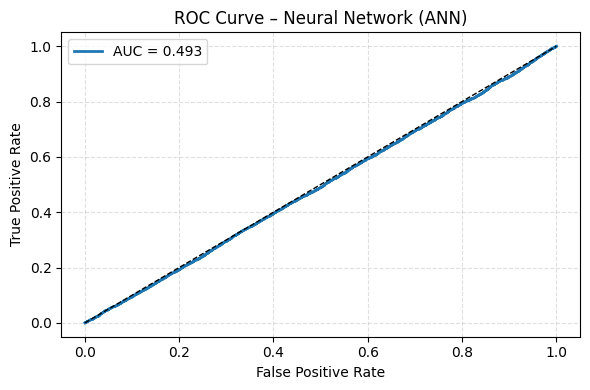

In [ ]:
# ============================================
# ROC CURVE FOR ANN
# ============================================

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--', linewidth=1)  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Neural Network (ANN)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


SVM Final


Training LinearSVC (C=1.0)...

LinearSVC performance (C=1.0):
Accuracy : 0.7009
Precision: 0.3505
Recall   : 0.5000
F1-score : 0.4121

Classification report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     14019
           1       0.00      0.00      0.00      5981

    accuracy                           0.70     20000
   macro avg       0.35      0.50      0.41     20000
weighted avg       0.49      0.70      0.58     20000



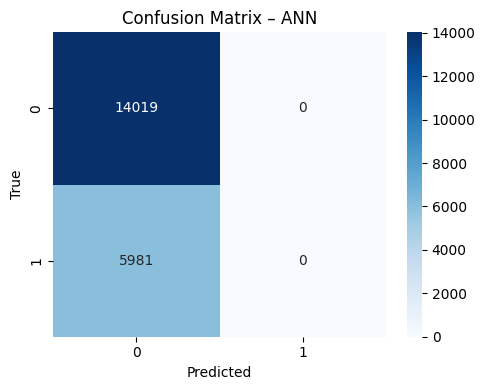

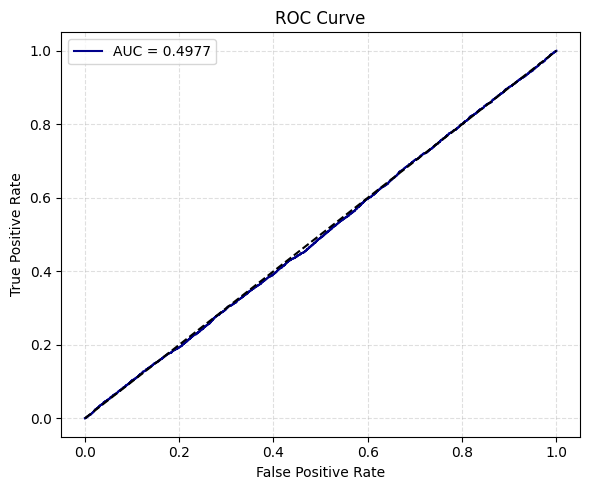

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Convert to numpy
X_train_svm = X_train.values
X_test_svm  = X_test.values

# ============================================
# TRAIN LinearSVC AND EVALUATE
# ============================================
print("\n===================================")
print("Training LinearSVC (C=1.0)...")
print("===================================")

lin_svm = LinearSVC(C=1.0, random_state=42, dual=False)
lin_svm.fit(X_train_svm, y_train)
y_pred = lin_svm.predict(X_test_svm)

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\nLinearSVC performance (C=1.0):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

# ============================================
# CONFUSION MATRIX
# ============================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ANN")
plt.tight_layout()
plt.show()


# ============================================
# ROC CURVE + AUC (use decision_function)
# ============================================
scores = lin_svm.decision_function(X_test_svm)
fpr, tpr, _ = roc_curve(y_test, scores)
auc_score = roc_auc_score(y_test, scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkblue")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



Tuning C for LinearSVC

C=0.001:  Accuracy=0.7009  |  F1-macro=0.4121
C=0.01:  Accuracy=0.7009  |  F1-macro=0.4121
C=0.1:  Accuracy=0.7009  |  F1-macro=0.4121
C=1:  Accuracy=0.7009  |  F1-macro=0.4121
C=10:  Accuracy=0.7009  |  F1-macro=0.4121
C=100:  Accuracy=0.7009  |  F1-macro=0.4121


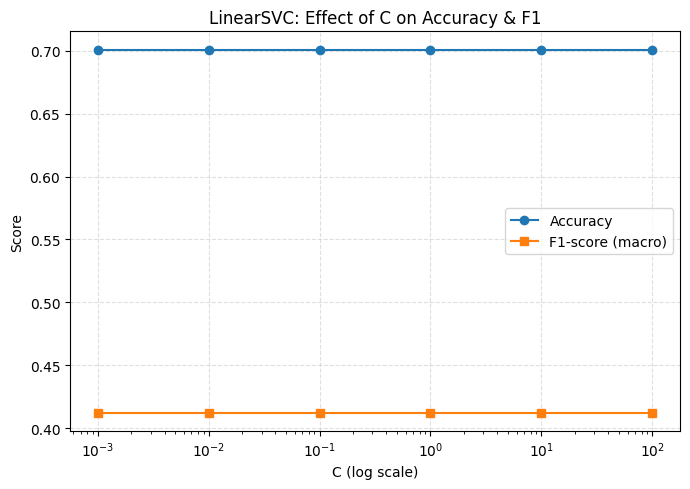

In [ ]:
# ============================================
# HYPERPARAMETER TUNING — VARY C FOR LinearSVC
# ============================================

from sklearn.svm import LinearSVC

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
acc_scores = []
f1_scores  = []

print("\n===================================")
print("Tuning C for LinearSVC")
print("===================================\n")

for C in C_values:
    clf = LinearSVC(C=C, random_state=42, dual=False)
    clf.fit(X_train_svm, y_train)
    y_pred_C = clf.predict(X_test_svm)

    acc_scores.append(accuracy_score(y_test, y_pred_C))
    f1_scores.append(f1_score(y_test, y_pred_C, average="macro", zero_division=0))

    print(f"C={C}:  Accuracy={acc_scores[-1]:.4f}  |  F1-macro={f1_scores[-1]:.4f}")

# ============================================
# PLOT RESULTS
# ============================================
plt.figure(figsize=(7, 5))
plt.plot(C_values, acc_scores, marker="o", label="Accuracy")
plt.plot(C_values, f1_scores, marker="s", label="F1-score (macro)")

plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Score")
plt.title("LinearSVC: Effect of C on Accuracy & F1")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



Tuning C for LinearSVC (class_weight='balanced')

C=0.001:  Accuracy=0.4985  |  F1-macro=0.4763
C=0.01:  Accuracy=0.4984  |  F1-macro=0.4759
C=0.1:  Accuracy=0.4992  |  F1-macro=0.4768
C=1:  Accuracy=0.4994  |  F1-macro=0.4768
C=10:  Accuracy=0.4994  |  F1-macro=0.4769
C=100:  Accuracy=0.4994  |  F1-macro=0.4768


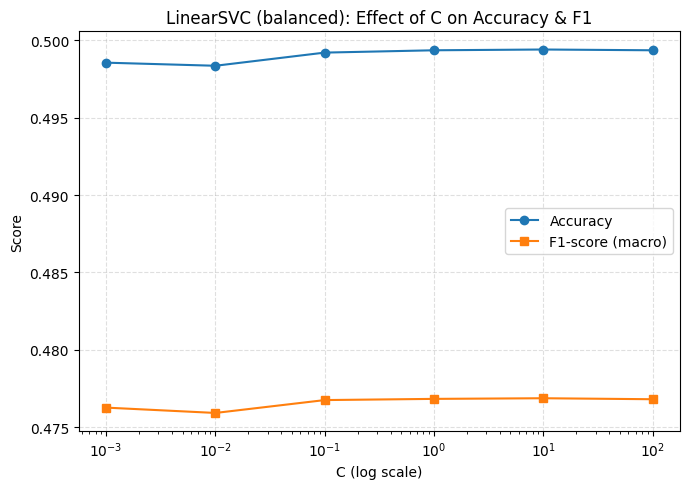

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
acc_scores = []
f1_scores  = []

print("\n===================================")
print("Tuning C for LinearSVC (class_weight='balanced')")
print("===================================\n")

for C in C_values:
    clf = LinearSVC(C=C, random_state=42, dual=False, class_weight='balanced')
    clf.fit(X_train_svm, y_train)
    y_pred_C = clf.predict(X_test_svm)

    acc_scores.append(accuracy_score(y_test, y_pred_C))
    f1_scores.append(f1_score(y_test, y_pred_C, average="macro", zero_division=0))

    print(f"C={C}:  Accuracy={acc_scores[-1]:.4f}  |  F1-macro={f1_scores[-1]:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(C_values, acc_scores, marker="o", label="Accuracy")
plt.plot(C_values, f1_scores, marker="s", label="F1-score (macro)")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Score")
plt.title("LinearSVC (balanced): Effect of C on Accuracy & F1")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-2440779198.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(svm_metrics.keys()), y=list(svm_metrics.values()), palette=colors)


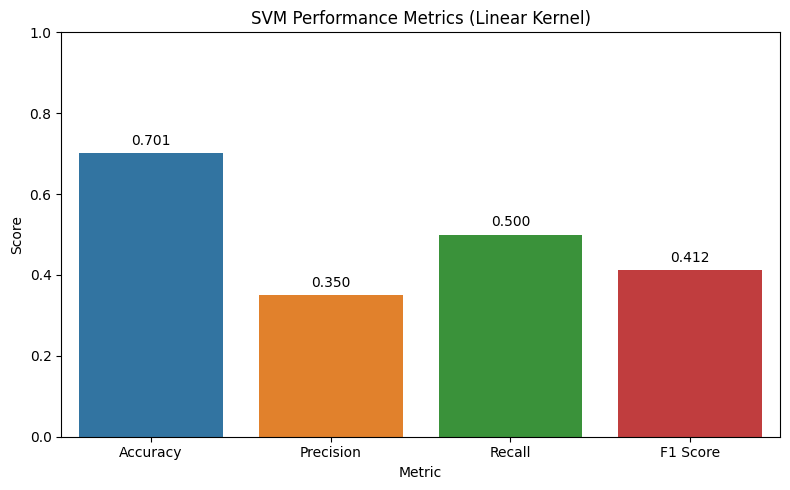

In [ ]:
# =======================================================
# SVM METRICS BAR PLOT
# =======================================================

# Store metrics
svm_metrics = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
}

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,5))
sns.barplot(x=list(svm_metrics.keys()), y=list(svm_metrics.values()), palette=colors)

plt.ylim(0, 1)
plt.title("SVM Performance Metrics (Linear Kernel)")
plt.ylabel("Score")
plt.xlabel("Metric")

# Annotate bars
for i, v in enumerate(svm_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Different Kernel Using (Full sample for training)

Full training size for kernel SVMs: 80000 samples

Training SVC (rbf kernel, C=1.0)...

SVC (rbf) performance:
Accuracy : 0.7009
Precision: 0.3505
Recall   : 0.5000
F1-score : 0.4121

Classification report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     14019
           1       0.00      0.00      0.00      5981

    accuracy                           0.70     20000
   macro avg       0.35      0.50      0.41     20000
weighted avg       0.49      0.70      0.58     20000



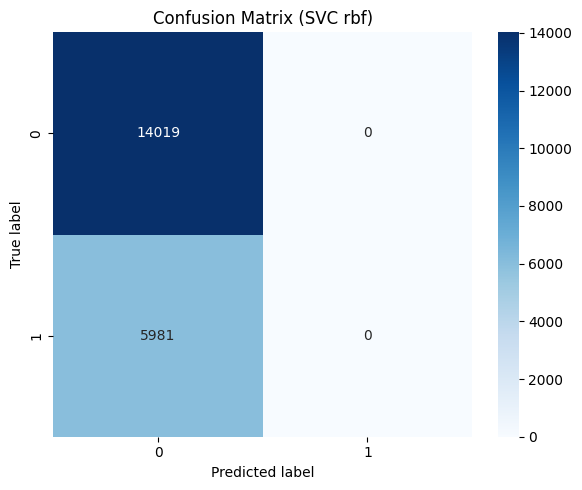

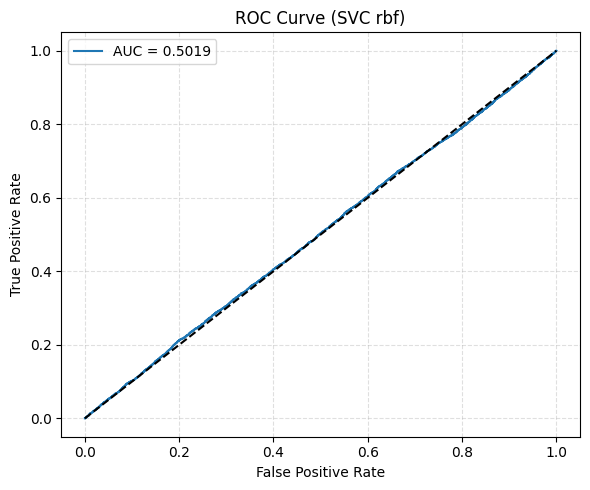


Training SVC (poly kernel, C=1.0)...

SVC (poly) performance:
Accuracy : 0.7008
Precision: 0.4933
Recall   : 0.5000
F1-score : 0.4124

Classification report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     14019
           1       0.29      0.00      0.00      5981

    accuracy                           0.70     20000
   macro avg       0.49      0.50      0.41     20000
weighted avg       0.58      0.70      0.58     20000



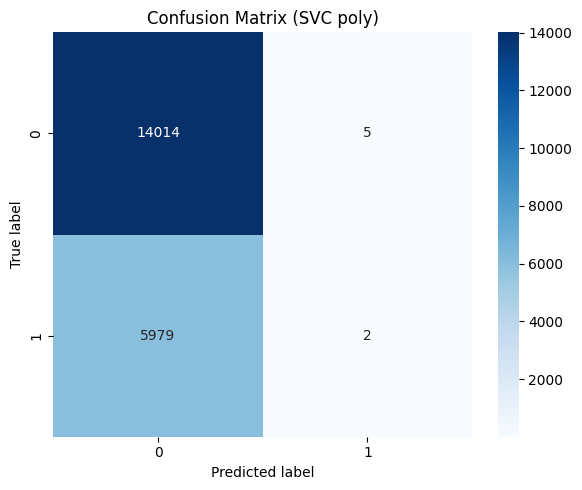

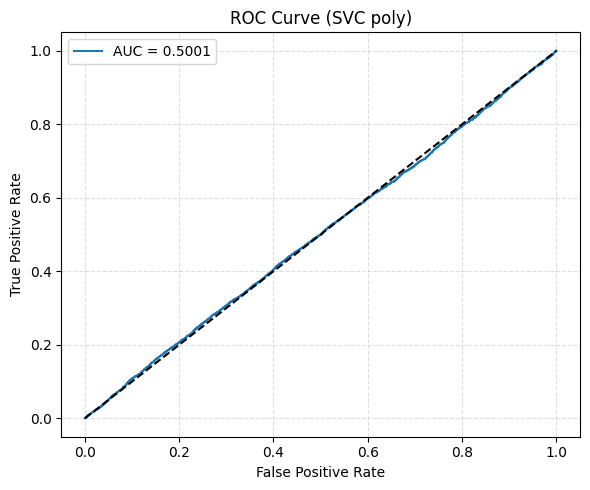


Training SVC (sigmoid kernel, C=1.0)...

SVC (sigmoid) performance:
Accuracy : 0.5934
Precision: 0.5093
Recall   : 0.5090
F1-score : 0.5091

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71     14019
           1       0.31      0.30      0.31      5981

    accuracy                           0.59     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.59      0.59      0.59     20000



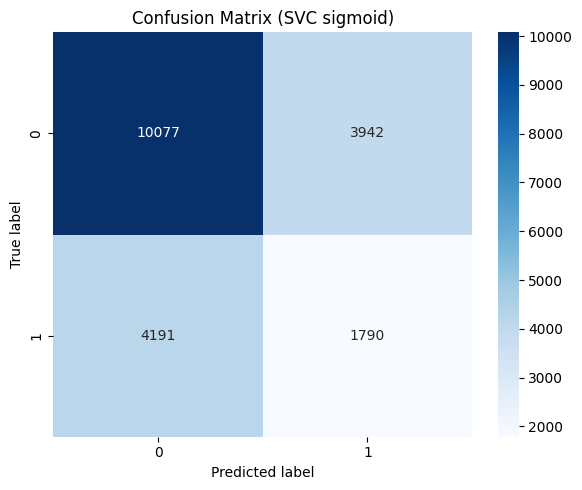

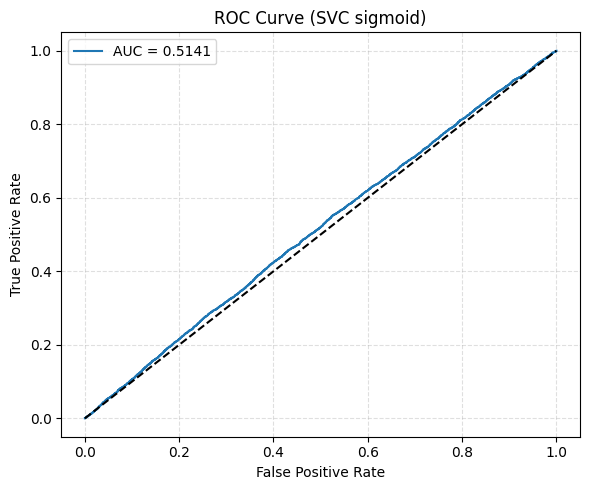

NameError: name 'acc_lin' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
from sklearn.svm import SVC   # make sure this import is present

# ============================================
# Use FULL training data for kernel SVMs
# ============================================
X_train_svm = X_train.values
X_test_svm  = X_test.values
y_train_svm = y_train.values

print(f"Full training size for kernel SVMs: {X_train_svm.shape[0]} samples")

# --------------------------------
# Scale features for kernels (full data)
# --------------------------------
scaler_k = StandardScaler()
X_train_k_scaled = scaler_k.fit_transform(X_train_svm)
X_test_k_scaled  = scaler_k.transform(X_test_svm)

# --------------------------------
# Helper: train + evaluate SVC with a given kernel
# --------------------------------
def train_eval_svc(kernel_name):
    print("\n===================================")
    print(f"Training SVC ({kernel_name} kernel, C=1.0)...")
    print("===================================")

    svc = SVC(kernel=kernel_name, C=1.0, gamma="scale", random_state=42)
    svc.fit(X_train_k_scaled, y_train_svm)
    y_pred_k = svc.predict(X_test_k_scaled)

    acc_k  = accuracy_score(y_test, y_pred_k)
    prec_k = precision_score(y_test, y_pred_k, average="macro", zero_division=0)
    rec_k  = recall_score(y_test, y_pred_k, average="macro", zero_division=0)
    f1_k   = f1_score(y_test, y_pred_k, average="macro", zero_division=0)

    print(f"\nSVC ({kernel_name}) performance:")
    print(f"Accuracy : {acc_k:.4f}")
    print(f"Precision: {prec_k:.4f}")
    print(f"Recall   : {rec_k:.4f}")
    print(f"F1-score : {f1_k:.4f}\n")

    print("Classification report:")
    print(classification_report(y_test, y_pred_k, zero_division=0))

    # Confusion matrix
    cm_k = confusion_matrix(y_test, y_pred_k)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_k, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Confusion Matrix (SVC {kernel_name})")
    plt.tight_layout()
    plt.show()

    # ROC curve
    scores_k = svc.decision_function(X_test_k_scaled)
    fpr_k, tpr_k, _ = roc_curve(y_test, scores_k)
    auc_k = roc_auc_score(y_test, scores_k)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_k, tpr_k, label=f"AUC = {auc_k:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (SVC {kernel_name})")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return acc_k, f1_k

# --------------------------------
# Train the three kernels on FULL training set
# --------------------------------
acc_rbf,  f1_rbf  = train_eval_svc("rbf")
acc_poly, f1_poly = train_eval_svc("poly")
acc_sig,  f1_sig  = train_eval_svc("sigmoid")

# --------------------------------
# Comparison bar plot with LinearSVC
# --------------------------------
models = ["LinearSVC", "RBF", "Poly", "Sigmoid"]
accs   = [acc_lin, acc_rbf, acc_poly, acc_sig]
f1s    = [f1_lin,  f1_rbf,  f1_poly,  f1_sig]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, accs, width, label="Accuracy")
plt.bar(x + width/2, f1s,  width, label="F1-score (macro)")
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.xlabel("Model / Kernel")
plt.ylabel("Score")
plt.title("Accuracy vs F1-score Across SVM Kernels")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


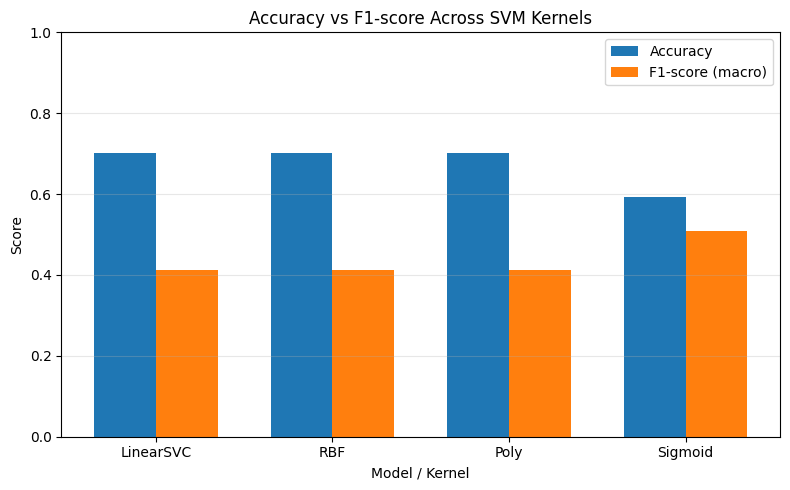

In [ ]:
# --------------------------------
# Comparison bar plot with LinearSVC
# --------------------------------
models = ["LinearSVC", "RBF", "Poly", "Sigmoid"]
accs   = [acc_lin, acc_rbf, acc_poly, acc_sig]
f1s    = [f1_lin,  f1_rbf,  f1_poly,  f1_sig]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, accs, width, label="Accuracy")
plt.bar(x + width/2, f1s,  width, label="F1-score (macro)")
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.xlabel("Model / Kernel")
plt.ylabel("Score")
plt.title("Accuracy vs F1-score Across SVM Kernels")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()